In [1]:
# BLOCK 1: INSTALL DEPENDENCIES

!pip install -q datasets transformers tensorflow pillow tqdm
!pip install -q tf-keras
!pip install -q accelerate
!pip install -q einops timm  # Required for Florence-2

import warnings
warnings.filterwarnings('ignore')

print("Done")

Done


Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

Dataset loaded successfully!
  Train samples: 68,980
  Validation samples: 8,618
  Test samples: 8,427

Features: {'screen_id': Value('string'), 'question': Value('string'), 'ground_truth': List(Value('string')), 'file_name': Value('string'), 'image': Image(mode=None, decode=True)}

Sample 1:
  Q: What is the default period length?...
  A: five days
  Image size: (1080, 1920)
  Screen ID: 0
  File name: images/rico/0.jpg

Sample 2:
  Q: What is the default cycle length?...
  A: 30
  Image size: (1080, 1920)
  Screen ID: 0
  File name: images/rico/0.jpg

Sample 3:
  Q: What is the start date of the last period?...
  A: Feb 10, 2017
  Image size: (1080, 1920)
  Screen ID: 0
  File name: images/rico/0.jpg


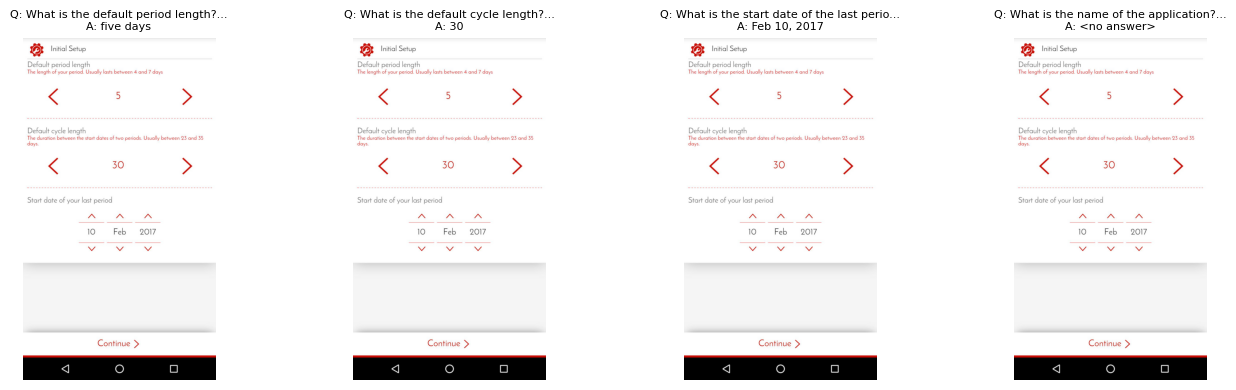

In [2]:
# BLOCK 2: LOAD DATASET

from datasets import load_from_disk
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Load dataset from disk
dataset = load_from_disk("/content/hf_datasets/RICO-ScreenQA-Short")

print(f"Dataset loaded successfully!")
print(f"  Train samples: {len(dataset['train']):,}")
print(f"  Validation samples: {len(dataset['validation']):,}")
print(f"  Test samples: {len(dataset['test']):,}")
print(f"\nFeatures: {dataset['train'].features}")

# Preview samples
for i in range(3):
    s = dataset['train'][i]
    print(f"\nSample {i+1}:")
    print(f"  Q: {s['question'][:60]}...")
    print(f"  A: {s['ground_truth'][0]}")
    print(f"  Image size: {s['image'].size}")
    print(f"  Screen ID: {s['screen_id']}")
    print(f"  File name: {s['file_name']}")

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
for i, ax in enumerate(axes):
    s = dataset['train'][i]
    ax.imshow(s['image'])
    ax.set_title(f"Q: {s['question'][:40]}...\nA: {s['ground_truth'][0][:15]}", fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.savefig('/content/samples.png', dpi=150)
plt.show()

In [3]:
# BLOCK 3: CONFIGURATION

import os

class Config:
    # Paths
    OCR_CACHE_PATH = "/content/ocr_cache.pkl"
    CHECKPOINT_PATH = "/content/checkpoints"

    # Image settings
    IMG_SIZE = 384  # EfficientNetV2-S input size

    # Text settings
    MAX_QUESTION_LEN = 64
    MAX_OCR_LEN = 256
    BERT_MODEL = "bert-base-uncased"

    # Model settings
    DENSE_UNITS = 512
    DROPOUT_RATE = 0.3

    # Training settings
    BATCH_SIZE = 16  # Adjusted for RTX 4070
    EPOCHS = 12
    FREEZE_EPOCHS = 3  # Epochs to keep backbone frozen
    LEARNING_RATE = 1e-4
    FINE_TUNE_LR = 1e-5

    # Hardware
    MIXED_PRECISION = True

config = Config()

# Create checkpoint directory
os.makedirs(config.CHECKPOINT_PATH, exist_ok=True)

print(f"  Image size: {config.IMG_SIZE}x{config.IMG_SIZE}")
print(f"  Batch size: {config.BATCH_SIZE}")
print(f"  Max question length: {config.MAX_QUESTION_LEN}")
print(f"  Max OCR length: {config.MAX_OCR_LEN}")

  Image size: 384x384
  Batch size: 16
  Max question length: 64
  Max OCR length: 256


In [4]:
# BLOCK 4: RUN OCR ON ALL IMAGES (Using Florence-2)

import torch
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import pickle
from tqdm.auto import tqdm
import gc
import time

# Check if OCR cache exists
if os.path.exists(config.OCR_CACHE_PATH):
    with open(config.OCR_CACHE_PATH, 'rb') as f:
        ocr_cache = pickle.load(f)
    print(f" Loaded {len(ocr_cache)} cached OCR results")
else:
    ocr_cache = {}


# Check Cache Status
splits_info = {}
total_needed = 0
total_cached = 0

for split_name in ['train', 'validation', 'test']:
    screen_ids = dataset[split_name]['screen_id']
    cached = sum(1 for sid in screen_ids if sid in ocr_cache)
    needed = len(screen_ids) - cached

    splits_info[split_name] = {'needed': needed, 'cached': cached, 'total': len(screen_ids)}
    total_needed += needed
    total_cached += cached
    print(f" {split_name}: {len(screen_ids)} total, {cached} cached, {needed} need OCR")

print(f"\nSummary")
print(f"Total: {total_cached + total_needed} | Cached: {total_cached} | Need OCR: {total_needed}")


# Florence-2 Model Setup
def setup_florence_ocr():
    model_name = "microsoft/Florence-2-base"
    print(f"Model: {model_name}")

    # Load model
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        trust_remote_code=True
    ).to("cuda")

    # Load processor
    processor = AutoProcessor.from_pretrained(
        model_name,
        trust_remote_code=True
    )

    model.eval()
    print(f"Model loaded on cuda")

    return model, processor

def extract_ocr_text_florence(model, processor, image):
    try:
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Resize if too large to save memory
        max_size = 768
        if max(image.size) > max_size:
            ratio = max_size / max(image.size)
            new_size = (int(image.size[0] * ratio), int(image.size[1] * ratio))
            image = image.resize(new_size, Image.LANCZOS)

        # Use OCR task prompt
        prompt = "<OCR>"

        inputs = processor(
            text=prompt,
            images=image,
            return_tensors="pt"
        ).to("cuda", torch.float16)

        with torch.no_grad():
            generated_ids = model.generate(
                input_ids=inputs["input_ids"],
                pixel_values=inputs["pixel_values"],
                max_new_tokens=512,
                num_beams=3,
                do_sample=False
            )

        generated_text = processor.batch_decode(
            generated_ids,
            skip_special_tokens=False
        )[0]

        # Parse the OCR output
        parsed = processor.post_process_generation(
            generated_text,
            task="<OCR>",
            image_size=(image.width, image.height)
        )

        # Extract text from parsed output
        if "<OCR>" in parsed:
            ocr_text = parsed["<OCR>"]
        else:
            ocr_text = str(parsed)

        return ocr_text.strip()

    except Exception as e:
        print(f"  OCR Error: {e}")
        return ""

def run_ocr_on_split(dataset_split, split_name, model, processor, ocr_cache):
    n_samples = len(dataset_split)
    ocr_texts = []
    new_extractions = 0
    cached_hits = 0

    screen_ids = dataset_split['screen_id']

    pbar = tqdm(
        range(n_samples),
        desc=f"OCR [{split_name}]",
        unit="img",
        ncols=100
    )

    for idx in pbar:
        screen_id = screen_ids[idx]

        if screen_id in ocr_cache:
            ocr_texts.append(ocr_cache[screen_id])
            cached_hits += 1
        else:
            image = dataset_split[idx]['image']
            ocr_text = extract_ocr_text_florence(model, processor, image)

            ocr_texts.append(ocr_text)
            ocr_cache[screen_id] = ocr_text
            new_extractions += 1

            # Save cache periodically
            if new_extractions % 500 == 0:
                with open(config.OCR_CACHE_PATH, 'wb') as f:
                    pickle.dump(ocr_cache, f)

        pbar.set_postfix({'new': new_extractions, 'cached': cached_hits})

    pbar.close()
    print(f"  {split_name}: {new_extractions} new, {cached_hits} cached")

    return ocr_texts, ocr_cache


# Run OCR Pipeline
if total_needed > 0:
    est_minutes = total_needed * 0.3 / 60  # Florence-2 is fast
    print(f"\nEstimated time: ~{est_minutes:.0f} minutes for {total_needed} images")

    # Load model
    ocr_model, ocr_processor = setup_florence_ocr()

    # Process each split
    train_ocr, ocr_cache = run_ocr_on_split(
        dataset['train'], 'train', ocr_model, ocr_processor, ocr_cache
    )

    val_ocr, ocr_cache = run_ocr_on_split(
        dataset['validation'], 'validation', ocr_model, ocr_processor, ocr_cache
    )

    test_ocr, ocr_cache = run_ocr_on_split(
        dataset['test'], 'test', ocr_model, ocr_processor, ocr_cache
    )

    # Save final cache
    with open(config.OCR_CACHE_PATH, 'wb') as f:
        pickle.dump(ocr_cache, f)
    print(f"Cache saved ({len(ocr_cache)} entries)")

    # Cleanup GPU memory
    del ocr_model, ocr_processor
    torch.cuda.empty_cache()
    gc.collect()

else:
    print("\nAll OCR cached! Loading from cache.")

    train_ids = dataset['train']['screen_id']
    val_ids = dataset['validation']['screen_id']
    test_ids = dataset['test']['screen_id']

    train_ocr = [ocr_cache[sid] for sid in tqdm(train_ids, desc="Load train")]
    val_ocr = [ocr_cache[sid] for sid in tqdm(val_ids, desc="Load val")]
    test_ocr = [ocr_cache[sid] for sid in tqdm(test_ids, desc="Load test")]


# Add OCR to Dataset
dataset['train'] = dataset['train'].add_column('ocr_text', train_ocr)
dataset['validation'] = dataset['validation'].add_column('ocr_text', val_ocr)
dataset['test'] = dataset['test'].add_column('ocr_text', test_ocr)


# Verify Results
for i in range(10):
    sample = dataset['train'][i]
    ocr_preview = sample['ocr_text'][:250] + "..." if len(sample['ocr_text']) > 250 else sample['ocr_text']
    print(f"\nSample {i+1}:")
    print(f"  Screen ID: {sample['screen_id']}")
    print(f"  Question: {sample['question']}")
    print(f"  OCR ({len(sample['ocr_text'])} chars): {ocr_preview if ocr_preview else '[EMPTY]'}")

 Loaded 35352 cached OCR results
 train: 68980 total, 68980 cached, 0 need OCR
 validation: 8618 total, 8618 cached, 0 need OCR
 test: 8427 total, 8427 cached, 0 need OCR

Summary
Total: 86025 | Cached: 86025 | Need OCR: 0

All OCR cached! Loading from cache.


Load train:   0%|          | 0/68980 [00:00<?, ?it/s]

Load val:   0%|          | 0/8618 [00:00<?, ?it/s]

Load test:   0%|          | 0/8427 [00:00<?, ?it/s]


Sample 1:
  Screen ID: 0
  Question: What is the default period length?
  OCR (252 chars): Initial SetupDefault period lengthThe length of your period. Usually lasts between 4 and 7 days5Default cycle lengthThe duration between the start dates of two periods. Usually between 23 and 35days.30Start date of your last period10Feb2017VContinue ...

Sample 2:
  Screen ID: 0
  Question: What is the default cycle length?
  OCR (252 chars): Initial SetupDefault period lengthThe length of your period. Usually lasts between 4 and 7 days5Default cycle lengthThe duration between the start dates of two periods. Usually between 23 and 35days.30Start date of your last period10Feb2017VContinue ...

Sample 3:
  Screen ID: 0
  Question: What is the start date of the last period?
  OCR (252 chars): Initial SetupDefault period lengthThe length of your period. Usually lasts between 4 and 7 days5Default cycle lengthThe duration between the start dates of two periods. Usually between 23 and 35days.30Start da

In [5]:
# BLOCK 5: SPAN EXTRACTION APPROACH
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast  #Using Fast tokenizer for offset_mapping
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# TOKENIZER

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# SPAN FINDING FUNCTION
#  Find start and end token positions of answer in OCR text. Returns (start_idx, end_idx) or (-1, -1) if not found.
def find_answer_span(answer, ocr_text, tokenizer, max_len):
    answer = answer.strip().lower()
    ocr_text = ocr_text.strip().lower() if ocr_text else ""

    if not ocr_text or not answer:
        return -1, -1

    # Find character position of answer in OCR text
    char_start = ocr_text.find(answer)
    if char_start == -1:
        return -1, -1

    char_end = char_start + len(answer)

    try:
        # Tokenize with offset mapping
        encoded = tokenizer(
            ocr_text,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        offsets = encoded['offset_mapping'][0].tolist()

        start_token = -1
        end_token = -1

        for idx, (token_start, token_end) in enumerate(offsets):
            # Skip special tokens [CLS], [SEP], [PAD]
            if token_start == 0 and token_end == 0:
                continue

            # Find start token
            if start_token == -1 and token_start <= char_start < token_end:
                start_token = idx

            # Find end token
            if token_start < char_end <= token_end:
                end_token = idx
                break

            # Handle multi-token spans
            if start_token != -1 and token_end >= char_end:
                end_token = idx
                break

        # Validate indices
        if start_token == -1 or end_token == -1:
            return -1, -1
        if start_token > end_token:
            return -1, -1
        if start_token >= max_len or end_token >= max_len:
            return -1, -1

        return start_token, end_token

    except Exception as e:
        return -1, -1

#  DATASET CLASS : Dataset for span extraction
class VQASpanDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, max_q_len, max_ocr_len, transform):
        self.dataset = hf_dataset
        self.tokenizer = tokenizer
        self.max_q_len = max_q_len
        self.max_ocr_len = max_ocr_len
        self.transform = transform

        # Pre-compute valid indices (where answer is in OCR)
        self.valid_indices = []
        self.spans = []

        for i in tqdm(range(len(hf_dataset)), desc="  Processing"):
            sample = hf_dataset[i]
            answer = sample['ground_truth'][0].strip().lower()
            ocr_text = sample['ocr_text'] or ""

            start, end = find_answer_span(answer, ocr_text, tokenizer, max_ocr_len)

            if start != -1 and end != -1:
                self.valid_indices.append(i)
                self.spans.append((start, end))

        print(f" Valid samples (answer in OCR): {len(self.valid_indices)} / {len(hf_dataset)} ({len(self.valid_indices)/len(hf_dataset)*100:.1f}%)")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        real_idx = self.valid_indices[idx]
        sample = self.dataset[real_idx]
        start_pos, end_pos = self.spans[idx]

        # Image
        image = sample['image']
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image_tensor = self.transform(image)

        # Question
        q_encoded = self.tokenizer(
            sample['question'],
            max_length=self.max_q_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # OCR
        ocr_text = (sample['ocr_text'] or "").lower()
        ocr_encoded = self.tokenizer(
            ocr_text,
            max_length=self.max_ocr_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'image': image_tensor,
            'question_ids': q_encoded['input_ids'].squeeze(0),
            'question_mask': q_encoded['attention_mask'].squeeze(0),
            'ocr_ids': ocr_encoded['input_ids'].squeeze(0),
            'ocr_mask': ocr_encoded['attention_mask'].squeeze(0),
            'start_pos': torch.tensor(start_pos, dtype=torch.long),
            'end_pos': torch.tensor(end_pos, dtype=torch.long),
            'answer': sample['ground_truth'][0].strip().lower(),
            'ocr_text': ocr_text,
            'question': sample['question']
        }

# IMAGE TRANSFORMS
image_transforms = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# CREATE DATASETS
print("\nTrain set:")
train_dataset = VQASpanDataset(
    dataset['train'], tokenizer,
    config.MAX_QUESTION_LEN, config.MAX_OCR_LEN, image_transforms
)

print("\nValidation set:")
val_dataset = VQASpanDataset(
    dataset['validation'], tokenizer,
    config.MAX_QUESTION_LEN, config.MAX_OCR_LEN, image_transforms
)

print("\nTest set:")
test_dataset = VQASpanDataset(
    dataset['test'], tokenizer,
    config.MAX_QUESTION_LEN, config.MAX_OCR_LEN, image_transforms
)

# DataLoaders
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


print(f"Train: {len(train_dataset)} samples, {len(train_loader)} batches")
print(f"Val: {len(val_dataset)} samples, {len(val_loader)} batches")
print(f"Test: {len(test_dataset)} samples, {len(test_loader)} batches")

# Quick test
batch = next(iter(train_loader))
print(f"Image shape: {batch['image'].shape}")
print(f"Question IDs shape: {batch['question_ids'].shape}")
print(f"OCR IDs shape: {batch['ocr_ids'].shape}")
print(f"Start positions: {batch['start_pos'][:5]}")
print(f"End positions: {batch['end_pos'][:5]}")

# Verify span extraction works
print("\nVerifying Span Extraction")
for i in range(3):
    ocr_ids = batch['ocr_ids'][i]
    start = batch['start_pos'][i].item()
    end = batch['end_pos'][i].item()
    true_answer = batch['answer'][i]

    # Decode extracted span
    extracted_tokens = ocr_ids[start:end+1].tolist()
    extracted_answer = tokenizer.decode(extracted_tokens, skip_special_tokens=True)

    print(f"\nSample {i+1}:")
    print(f"  Question: {batch['question'][i][:50]}...")
    print(f"  True answer: '{true_answer}'")
    print(f"  Extracted span [{start}:{end}]: '{extracted_answer}'")
    print(f"  Match: {'✓' if extracted_answer.strip().lower() == true_answer.strip().lower() else '✗'}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4070

Train set:


  Processing:   0%|          | 0/68980 [00:00<?, ?it/s]

 Valid samples (answer in OCR): 33941 / 68980 (49.2%)

Validation set:


  Processing:   0%|          | 0/8618 [00:00<?, ?it/s]

 Valid samples (answer in OCR): 3692 / 8618 (42.8%)

Test set:


  Processing:   0%|          | 0/8427 [00:00<?, ?it/s]

 Valid samples (answer in OCR): 3760 / 8427 (44.6%)
Train: 33941 samples, 2122 batches
Val: 3692 samples, 231 batches
Test: 3760 samples, 235 batches
Image shape: torch.Size([16, 3, 384, 384])
Question IDs shape: torch.Size([16, 64])
OCR IDs shape: torch.Size([16, 256])
Start positions: tensor([13, 50, 30, 17,  5])
End positions: tensor([16, 52, 37, 18,  7])

Verifying Span Extraction

Sample 1:
  Question: What duration is given for one flashcard?...
  True answer: '<10 mins'
  Extracted span [13:16]: '< 10 mins'
  Match: ✗

Sample 2:
  Question: What percentage is off on the machines?...
  True answer: '30% off'
  Extracted span [50:52]: '30 % off'
  Match: ✗

Sample 3:
  Question: Who is known as "Sparrow man"?...
  True answer: 'jagatbhai kinkhabwala'
  Extracted span [30:37]: '##jagatbhai kinkhabwala'
  Match: ✗


In [6]:
# BLOCK 6: SPAN EXTRACTION MODEL

import torch
import torch.nn as nn
import timm
from transformers import BertModel


# VQA model that extracts answer span from OCR text.
# Predicts start and end positions in OCR token sequence.
class VQASpanModel(nn.Module):

    def __init__(self, max_ocr_len, dropout=0.3):
        super().__init__()
        self.max_ocr_len = max_ocr_len

        # Image encoder
        self.image_encoder = timm.create_model('tf_efficientnetv2_s', pretrained=True, num_classes=0)
        self.image_dim = self.image_encoder.num_features  # 1280
        for param in self.image_encoder.parameters():
            param.requires_grad = False

        # Question BERT
        self.question_bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.question_bert.parameters():
            param.requires_grad = False

        # OCR BERT
        self.ocr_bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.ocr_bert.parameters():
            param.requires_grad = False

        self.text_dim = 768

        # Fusion: combine image + question features
        self.context_fusion = nn.Sequential(
            nn.Linear(self.image_dim + self.text_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, self.text_dim)  # Project to BERT dim
        )

        # Span prediction heads
        # Takes OCR hidden states + context and predicts start/end
        self.start_head = nn.Linear(self.text_dim * 2, 1)
        self.end_head = nn.Linear(self.text_dim * 2, 1)

        print(f"Model built for span extraction over {max_ocr_len} OCR tokens")

    def forward(self, image, question_ids, question_mask, ocr_ids, ocr_mask):
        batch_size = image.size(0)

        # Image features [B, 1280]
        image_features = self.image_encoder(image)

        # Question features [B, 768]
        q_output = self.question_bert(input_ids=question_ids, attention_mask=question_mask)
        question_features = q_output.pooler_output

        # OCR token-level features [B, seq_len, 768]
        ocr_output = self.ocr_bert(input_ids=ocr_ids, attention_mask=ocr_mask)
        ocr_hidden = ocr_output.last_hidden_state  # [B, max_ocr_len, 768]

        # Create context vector from image + question
        context = torch.cat([image_features, question_features], dim=1)  # [B, 2048]
        context = self.context_fusion(context)  # [B, 768]

        # Expand context to match OCR sequence length
        context_expanded = context.unsqueeze(1).expand(-1, self.max_ocr_len, -1)  # [B, seq_len, 768]

        # Concatenate OCR hidden states with context
        combined = torch.cat([ocr_hidden, context_expanded], dim=2)  # [B, seq_len, 1536]

        # Predict start and end positions
        start_logits = self.start_head(combined).squeeze(-1)  # [B, seq_len]
        end_logits = self.end_head(combined).squeeze(-1)  # [B, seq_len]

        # Mask padding tokens (set to large negative)
        mask = (ocr_mask == 0)
        start_logits = start_logits.masked_fill(mask, -1e9)
        end_logits = end_logits.masked_fill(mask, -1e9)

        return start_logits, end_logits

    def unfreeze_for_finetuning(self):
        # Unfreeze OCR BERT (most important for span extraction)
        for param in self.ocr_bert.encoder.layer[-4:].parameters():
            param.requires_grad = True
        for param in self.ocr_bert.pooler.parameters():
            param.requires_grad = True

        # Unfreeze some image encoder
        for name, param in self.image_encoder.named_parameters():
            if 'blocks.5' in name or 'blocks.6' in name:
                param.requires_grad = True

        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Trainable params after unfreeze: {trainable:,}")

# Create model
model = VQASpanModel(max_ocr_len=config.MAX_OCR_LEN, dropout=config.DROPOUT_RATE)
model = model.to(device)

# Test forward pass
print("\nTesting forward pass...")
batch = next(iter(train_loader))
with torch.no_grad():
    start_logits, end_logits = model(
        batch['image'].to(device),
        batch['question_ids'].to(device),
        batch['question_mask'].to(device),
        batch['ocr_ids'].to(device),
        batch['ocr_mask'].to(device)
    )
print(f"Start logits: {start_logits.shape}")
print(f"End logits: {end_logits.shape}")

Model built for span extraction over 256 OCR tokens

Testing forward pass...
Start logits: torch.Size([16, 256])
End logits: torch.Size([16, 256])



PHASE 1: Frozen backbone (3 epochs)

Epoch 1/3


Training:   0%|          | 0/2122 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/231 [00:00<?, ?it/s]

  Train Loss: 3.5550 | Train Span Acc: 0.0264
  Val Loss: 3.3488 | Val Exact Match: 0.0095
Best model saved (EM: 0.0095)

Epoch 2/3


Training:   0%|          | 0/2122 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/231 [00:00<?, ?it/s]

  Train Loss: 3.3182 | Train Span Acc: 0.0438
  Val Loss: 3.2548 | Val Exact Match: 0.0106
Best model saved (EM: 0.0106)

Epoch 3/3


Training:   0%|          | 0/2122 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/231 [00:00<?, ?it/s]

  Train Loss: 3.2603 | Train Span Acc: 0.0519
  Val Loss: 3.2130 | Val Exact Match: 0.0160
Best model saved (EM: 0.0160)

PHASE 2: Fine-tuning (9 epochs)
Trainable params after unfreeze: 44,950,058

Epoch 1/9


Training:   0%|          | 0/2122 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/231 [00:00<?, ?it/s]

  Train Loss: 2.9667 | Train Span Acc: 0.0944
  Val Loss: 2.8203 | Val Exact Match: 0.0347
Best model saved (EM: 0.0347)

Epoch 2/9


Training:   0%|          | 0/2122 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/231 [00:00<?, ?it/s]

  Train Loss: 2.7262 | Train Span Acc: 0.1321
  Val Loss: 2.7140 | Val Exact Match: 0.0274

Epoch 3/9


Training:   0%|          | 0/2122 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/231 [00:00<?, ?it/s]

  Train Loss: 2.6007 | Train Span Acc: 0.1502
  Val Loss: 2.6655 | Val Exact Match: 0.0382
Best model saved (EM: 0.0382)

Epoch 4/9


Training:   0%|          | 0/2122 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/231 [00:00<?, ?it/s]

  Train Loss: 2.5010 | Train Span Acc: 0.1635
  Val Loss: 2.6293 | Val Exact Match: 0.0433
Best model saved (EM: 0.0433)

Epoch 5/9


Training:   0%|          | 0/2122 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/231 [00:00<?, ?it/s]

  Train Loss: 2.4134 | Train Span Acc: 0.1770
  Val Loss: 2.6359 | Val Exact Match: 0.0439
Best model saved (EM: 0.0439)

Epoch 6/9


Training:   0%|          | 0/2122 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/231 [00:00<?, ?it/s]

  Train Loss: 2.3330 | Train Span Acc: 0.1909
  Val Loss: 2.6492 | Val Exact Match: 0.0414

Epoch 7/9


Training:   0%|          | 0/2122 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/231 [00:00<?, ?it/s]

  Train Loss: 2.2532 | Train Span Acc: 0.1998
  Val Loss: 2.6329 | Val Exact Match: 0.0431

Epoch 8/9


Training:   0%|          | 0/2122 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/231 [00:00<?, ?it/s]

  Train Loss: 2.1780 | Train Span Acc: 0.2095
  Val Loss: 2.6689 | Val Exact Match: 0.0493
Best model saved (EM: 0.0493)

Epoch 9/9


Training:   0%|          | 0/2122 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/231 [00:00<?, ?it/s]

  Train Loss: 2.1085 | Train Span Acc: 0.2224
  Val Loss: 2.6970 | Val Exact Match: 0.0436


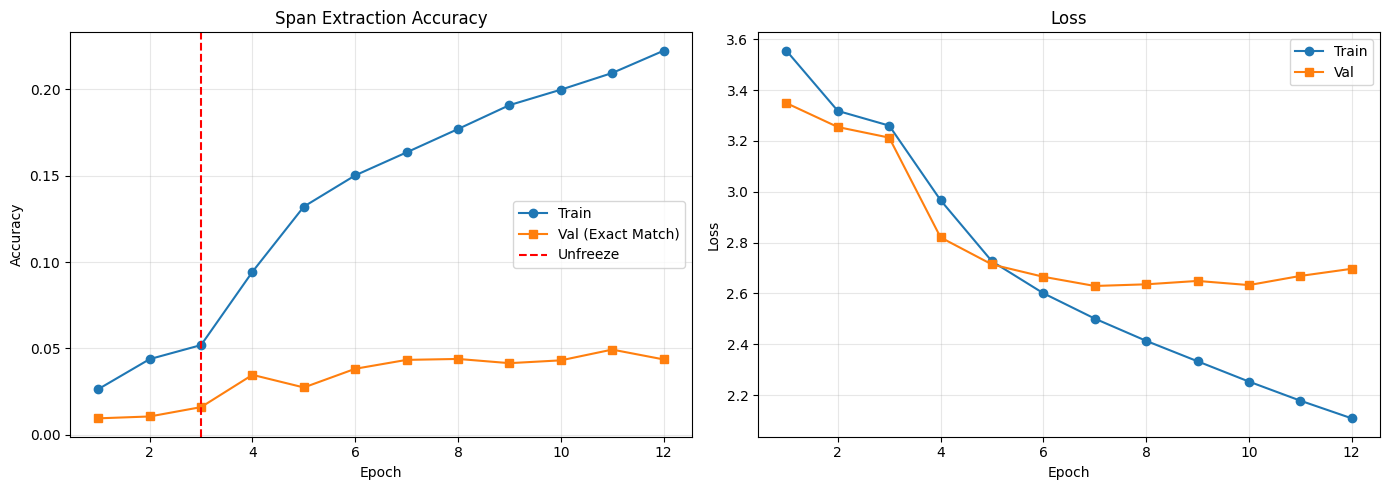


Best Exact Match: 0.0493
Total time: 180.4 minutes


In [7]:
# BLOCK 7: TRAIN SPAN EXTRACTION MODEL

import time
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm


# Decode answer from token IDs given start and end positions.
def decode_answer(ocr_ids, start_idx, end_idx, tokenizer):
    if start_idx > end_idx or start_idx < 0:
        return ""
    tokens = ocr_ids[start_idx:end_idx+1].tolist()
    answer = tokenizer.decode(tokens, skip_special_tokens=True)
    return answer.strip()


def compute_exact_match(pred_answer, true_answer):
    return pred_answer.strip().lower() == true_answer.strip().lower()

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    criterion = nn.CrossEntropyLoss()

    pbar = tqdm(dataloader, desc="Training", leave=False)
    for batch in pbar:
        image = batch['image'].to(device)
        q_ids = batch['question_ids'].to(device)
        q_mask = batch['question_mask'].to(device)
        ocr_ids = batch['ocr_ids'].to(device)
        ocr_mask = batch['ocr_mask'].to(device)
        start_pos = batch['start_pos'].to(device)
        end_pos = batch['end_pos'].to(device)

        optimizer.zero_grad()

        start_logits, end_logits = model(image, q_ids, q_mask, ocr_ids, ocr_mask)

        # Loss for start and end positions
        start_loss = criterion(start_logits, start_pos)
        end_loss = criterion(end_logits, end_pos)
        loss = (start_loss + end_loss) / 2

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

        # Compute accuracy (both start AND end must be correct)
        pred_start = start_logits.argmax(dim=1)
        pred_end = end_logits.argmax(dim=1)
        correct += ((pred_start == start_pos) & (pred_end == end_pos)).sum().item()
        total += start_pos.size(0)

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{correct/total:.4f}'})

    return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader, device, tokenizer):
    model.eval()
    total_loss = 0
    exact_matches = 0
    total = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            image = batch['image'].to(device)
            q_ids = batch['question_ids'].to(device)
            q_mask = batch['question_mask'].to(device)
            ocr_ids = batch['ocr_ids'].to(device)
            ocr_mask = batch['ocr_mask'].to(device)
            start_pos = batch['start_pos'].to(device)
            end_pos = batch['end_pos'].to(device)
            true_answers = batch['answer']

            start_logits, end_logits = model(image, q_ids, q_mask, ocr_ids, ocr_mask)

            start_loss = criterion(start_logits, start_pos)
            end_loss = criterion(end_logits, end_pos)
            loss = (start_loss + end_loss) / 2
            total_loss += loss.item()

            # Decode predictions and compute exact match
            pred_starts = start_logits.argmax(dim=1)
            pred_ends = end_logits.argmax(dim=1)

            for i in range(len(true_answers)):
                pred_answer = decode_answer(
                    ocr_ids[i].cpu(),
                    pred_starts[i].item(),
                    pred_ends[i].item(),
                    tokenizer
                )
                if compute_exact_match(pred_answer, true_answers[i]):
                    exact_matches += 1
                total += 1

    return total_loss / len(dataloader), exact_matches / total

# TRAINING SETUP
optimizer = AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0
best_model_path = os.path.join(config.CHECKPOINT_PATH, 'best_span_model.pt')

# FROZEN
print(f"\nPHASE 1: Frozen backbone ({config.FREEZE_EPOCHS} epochs)")

start_time = time.time()

for epoch in range(config.FREEZE_EPOCHS):
    print(f"\nEpoch {epoch+1}/{config.FREEZE_EPOCHS}")

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, device, tokenizer)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"  Train Loss: {train_loss:.4f} | Train Span Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Val Exact Match: {val_acc:.4f}")

    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved (EM: {val_acc:.4f})")

phase1_time = time.time() - start_time

# FINE-TUNING
print(f"\nPHASE 2: Fine-tuning ({config.EPOCHS - config.FREEZE_EPOCHS} epochs)")

model.unfreeze_for_finetuning()

optimizer = AdamW([
    {'params': model.context_fusion.parameters(), 'lr': config.LEARNING_RATE},
    {'params': model.start_head.parameters(), 'lr': config.LEARNING_RATE},
    {'params': model.end_head.parameters(), 'lr': config.LEARNING_RATE},
    {'params': model.ocr_bert.parameters(), 'lr': config.FINE_TUNE_LR},
    {'params': model.image_encoder.parameters(), 'lr': config.FINE_TUNE_LR},
], weight_decay=0.01)

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

start_time = time.time()

for epoch in range(config.EPOCHS - config.FREEZE_EPOCHS):
    print(f"\nEpoch {epoch+1}/{config.EPOCHS - config.FREEZE_EPOCHS}")

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, device, tokenizer)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"  Train Loss: {train_loss:.4f} | Train Span Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Val Exact Match: {val_acc:.4f}")

    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved (EM: {val_acc:.4f})")

phase2_time = time.time() - start_time

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
epochs_range = range(1, len(history['train_loss']) + 1)

axes[0].plot(epochs_range, history['train_acc'], 'o-', label='Train')
axes[0].plot(epochs_range, history['val_acc'], 's-', label='Val (Exact Match)')
axes[0].axvline(x=config.FREEZE_EPOCHS, color='r', linestyle='--', label='Unfreeze')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Span Extraction Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_range, history['train_loss'], 'o-', label='Train')
axes[1].plot(epochs_range, history['val_loss'], 's-', label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/span_training_history.png', dpi=150)
plt.show()

print(f"\nBest Exact Match: {best_val_acc:.4f}")
print(f"Total time: {(phase1_time + phase2_time)/60:.1f} minutes")

In [8]:
#  BLOCK 8: EVALUATION

import random
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.auto import tqdm
import numpy as np
import csv


def decode_span(ocr_ids, start_idx, end_idx, tokenizer):
    """Decode answer from token span."""
    if start_idx > end_idx or start_idx < 0:
        return ""
    tokens = ocr_ids[start_idx:end_idx+1].tolist()
    return tokenizer.decode(tokens, skip_special_tokens=True).strip()

# Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()


#EVALUATE ALL TEST SAMPLES

all_results = []
correct_results = []
incorrect_results = []

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(test_loader, desc="Predicting")):
        image = batch['image'].to(device)
        q_ids = batch['question_ids'].to(device)
        q_mask = batch['question_mask'].to(device)
        ocr_ids = batch['ocr_ids'].to(device)
        ocr_mask = batch['ocr_mask'].to(device)

        start_logits, end_logits = model(image, q_ids, q_mask, ocr_ids, ocr_mask)

        pred_starts = start_logits.argmax(dim=1)
        pred_ends = end_logits.argmax(dim=1)

        for i in range(len(batch['answer'])):
            pred_start = pred_starts[i].item()
            pred_end = pred_ends[i].item()

            pred_answer = decode_span(batch['ocr_ids'][i], pred_start, pred_end, tokenizer)
            true_answer = batch['answer'][i]
            question = batch['question'][i]

            # Get confidence scores
            start_probs = torch.softmax(start_logits[i], dim=0)
            end_probs = torch.softmax(end_logits[i], dim=0)
            start_conf = start_probs[pred_start].item()
            end_conf = end_probs[pred_end].item()

            is_correct = pred_answer.strip().lower() == true_answer.strip().lower()

            result = {
                'batch_idx': batch_idx,
                'sample_idx': i,
                'idx': batch_idx * test_loader.batch_size + i,  # Global index
                'question': question,
                'predicted': pred_answer,
                'ground_truth': true_answer,
                'start_conf': start_conf,
                'end_conf': end_conf,
                'avg_conf': (start_conf + end_conf) / 2,
                'correct': is_correct
            }

            all_results.append(result)

            if is_correct:
                correct_results.append(result)
            else:
                incorrect_results.append(result)

        if batch_idx % 50 == 0:
            torch.cuda.empty_cache()

#  ACCURACY SUMMARY
total = len(all_results)
correct = len(correct_results)
incorrect = len(incorrect_results)
accuracy = correct / total


print("\nACCURACY SUMMARY")
print(f"Total samples: {total}")
print(f"Correct: {correct} ({correct/total*100:.2f}%)")
print(f"Incorrect: {incorrect} ({incorrect/total*100:.2f}%)")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# GRAPHS
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Accuracy Pie Chart
ax1 = axes[0, 0]
sizes = [correct, incorrect]
labels = [f'Correct\n({correct})', f'Incorrect\n({incorrect})']
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0)
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title(f'Overall Accuracy: {accuracy*100:.2f}%', fontsize=14, fontweight='bold')

# Plot 2: Confidence Distribution
ax2 = axes[0, 1]
correct_confs = [r['avg_conf'] for r in correct_results]
incorrect_confs = [r['avg_conf'] for r in incorrect_results]

ax2.hist(correct_confs, bins=20, alpha=0.7, label='Correct', color='#2ecc71', edgecolor='black')
ax2.hist(incorrect_confs, bins=20, alpha=0.7, label='Incorrect', color='#e74c3c', edgecolor='black')
ax2.set_xlabel('Confidence Score', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Confidence Distribution', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Answer Length Distribution
ax3 = axes[0, 2]
correct_lens = [len(r['predicted']) for r in correct_results]
incorrect_lens = [len(r['predicted']) for r in incorrect_results]

ax3.hist(correct_lens, bins=15, alpha=0.7, label='Correct', color='#2ecc71', edgecolor='black')
ax3.hist(incorrect_lens, bins=15, alpha=0.7, label='Incorrect', color='#e74c3c', edgecolor='black')
ax3.set_xlabel('Predicted Answer Length (chars)', fontsize=12)
ax3.set_ylabel('Count', fontsize=12)
ax3.set_title('Predicted Answer Length Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Question Length Distribution
ax4 = axes[1, 0]
correct_q_lens = [len(r['question']) for r in correct_results]
incorrect_q_lens = [len(r['question']) for r in incorrect_results]

ax4.hist(correct_q_lens, bins=15, alpha=0.7, label='Correct', color='#2ecc71', edgecolor='black')
ax4.hist(incorrect_q_lens, bins=15, alpha=0.7, label='Incorrect', color='#e74c3c', edgecolor='black')
ax4.set_xlabel('Question Length (chars)', fontsize=12)
ax4.set_ylabel('Count', fontsize=12)
ax4.set_title('Question Length Distribution', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)


plt.tight_layout()
plt.savefig('/content/span_evaluation_graphs.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved graphs to /content/span_evaluation_graphs.png")

# SHOW IMAGES FUNCTION
def show_predictions_with_images(results_list, title, color, num_samples=25):
    """Display predictions with images."""
    n = min(num_samples, len(results_list))
    if n == 0:
        print(f"No samples to show for {title}")
        return

    cols = 5
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(20, 4.5 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()

    for i in range(rows * cols):
        ax = axes[i]
        if i < n:
            r = results_list[i]

            # Get image from test_dataset
            try:
                sample_idx = r['idx']
                if sample_idx < len(test_dataset):
                    real_idx = test_dataset.valid_indices[sample_idx]
                    sample = dataset['test'][real_idx]
                    ax.imshow(sample['image'])
                else:
                    ax.text(0.5, 0.5, 'Image N/A', ha='center', va='center')
            except:
                ax.text(0.5, 0.5, 'Image N/A', ha='center', va='center')

            q = r['question'][:32] + '...' if len(r['question']) > 32 else r['question']
            pred = r['predicted'][:18] + '...' if len(r['predicted']) > 18 else r['predicted']
            true = r['ground_truth'][:18] + '...' if len(r['ground_truth']) > 18 else r['ground_truth']
            conf = r['avg_conf']

            if r['correct']:
                title_text = f"Q: {q}\nA: {pred} ({conf:.1%})"
            else:
                title_text = f"Q: {q}\nPred: {pred}\nTrue: {true}"

            ax.set_title(title_text, fontsize=8, color=color, fontweight='bold')
        ax.axis('off')

    plt.suptitle(f"{title} ({n} samples)", fontsize=14, fontweight='bold', color=color)
    plt.tight_layout()
    filename = f'/content/{title.lower().replace(" ", "_").replace("(", "").replace(")", "")}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f" Saved to {filename}")

#  CORRECT PREDICTIONS WITH IMAGES
print("CORRECT PREDICTIONS WITH IMAGES")
print(f"Total correct: {len(correct_results)}")

# Show first 25 correct
show_predictions_with_images(correct_results[:25], "Correct Predictions (1-25)", "green", 25)

# Show next 25 correct
if len(correct_results) > 25:
    show_predictions_with_images(correct_results[25:50], "Correct Predictions (26-50)", "green", 25)

# Show next 25 correct
if len(correct_results) > 50:
    show_predictions_with_images(correct_results[50:75], "Correct Predictions (51-75)", "green", 25)

# Show next 25 correct
if len(correct_results) > 75:
    show_predictions_with_images(correct_results[75:100], "Correct Predictions (76-100)", "green", 25)

#  INCORRECT PREDICTIONS WITH IMAGES
print("INCORRECT PREDICTIONS WITH IMAGES")
print(f"Total incorrect: {len(incorrect_results)}")

# Show first 25 incorrect
show_predictions_with_images(incorrect_results[:25], "Incorrect Predictions (1-25)", "red", 25)

# Show next 25 incorrect
if len(incorrect_results) > 25:
    show_predictions_with_images(incorrect_results[25:50], "Incorrect Predictions (26-50)", "red", 25)

# Show next 25 incorrect
if len(incorrect_results) > 50:
    show_predictions_with_images(incorrect_results[50:75], "Incorrect Predictions (51-75)", "red", 25)

# Show next 25 incorrect
if len(incorrect_results) > 75:
    show_predictions_with_images(incorrect_results[75:100], "Incorrect Predictions (76-100)", "red", 25)

# SIDE-BY-SIDE COMPARISON
print("SIDE-BY-SIDE: CORRECT vs INCORRECT")

fig, axes = plt.subplots(2, 5, figsize=(20, 9))

# Top row: Correct predictions
for i in range(5):
    ax = axes[0, i]
    if i < len(correct_results):
        r = correct_results[i]
        try:
            sample_idx = r['idx']
            if sample_idx < len(test_dataset):
                real_idx = test_dataset.valid_indices[sample_idx]
                sample = dataset['test'][real_idx]
                ax.imshow(sample['image'])
        except:
            pass
        q = r['question'][:28] + '...' if len(r['question']) > 28 else r['question']
        ax.set_title(f"✓ Q: {q}\nA: {r['predicted']}", fontsize=8, color='green', fontweight='bold')
    ax.axis('off')

# Bottom row: Incorrect predictions
for i in range(5):
    ax = axes[1, i]
    if i < len(incorrect_results):
        r = incorrect_results[i]
        try:
            sample_idx = r['idx']
            if sample_idx < len(test_dataset):
                real_idx = test_dataset.valid_indices[sample_idx]
                sample = dataset['test'][real_idx]
                ax.imshow(sample['image'])
        except:
            pass
        q = r['question'][:28] + '...' if len(r['question']) > 28 else r['question']
        ax.set_title(f"✗ Q: {q}\nPred: {r['predicted']}\nTrue: {r['ground_truth']}",
                    fontsize=8, color='red', fontweight='bold')
    ax.axis('off')

plt.suptitle("Top: Correct | Bottom: Incorrect", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/side_by_side_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# STATISTICS
avg_conf_correct = np.mean([r['avg_conf'] for r in correct_results]) if correct_results else 0
avg_conf_incorrect = np.mean([r['avg_conf'] for r in incorrect_results]) if incorrect_results else 0

print(f"Correct predictions: {len(correct_results)}")
print(f"Incorrect predictions: {len(incorrect_results)}")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\nAverage confidence (correct): {avg_conf_correct:.4f}")
print(f"Average confidence (incorrect): {avg_conf_incorrect:.4f}")

if correct_results:
    ans_lengths = [len(r['predicted']) for r in correct_results]
    print(f"\nCorrect answer length stats:")
    print(f"  Min: {min(ans_lengths)} chars")
    print(f"  Max: {max(ans_lengths)} chars")
    print(f"  Avg: {np.mean(ans_lengths):.1f} chars")

# TEXT TABLES
print("\n" )
print("100 CORRECT PREDICTIONS (Text)")
print(f"{'#':<5} {'CONF':<8} {'QUESTION':<45} {'ANSWER':<35}")

for i, r in enumerate(correct_results[:100], 1):
    q = r['question'][:42] + '...' if len(r['question']) > 42 else r['question']
    a = r['predicted'][:32] + '...' if len(r['predicted']) > 32 else r['predicted']
    print(f"{i:<5} {r['avg_conf']:<8.1%} {q:<45} {a:<35}")

print("\n" )
print("100 INCORRECT PREDICTIONS (Text)")
print(f"{'#':<5} {'QUESTION':<40} {'PREDICTED':<25} {'GROUND TRUTH':<25}")

for i, r in enumerate(incorrect_results[:100], 1):
    q = r['question'][:37] + '...' if len(r['question']) > 37 else r['question']
    p = r['predicted'][:22] + '...' if len(r['predicted']) > 22 else r['predicted']
    g = r['ground_truth'][:22] + '...' if len(r['ground_truth']) > 22 else r['ground_truth']
    print(f"{i:<5} {q:<40} {p:<25} {g:<25}")

print("FINAL SUMMARY:")
print(f"Total Tested: {total}")
print(f"Correct: {correct} ({correct/total*100:.2f}%)")
print(f"Incorrect: {incorrect} ({incorrect/total*100:.2f}%)")
print(f"Accuracy: {accuracy:.4f}")

Output hidden; open in https://colab.research.google.com to view.